In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image

In [2]:
from skimage import color

In [3]:
# Loaded a set of images
root_dir = "training/"
image_dir = root_dir + "images/"
gt_dir = root_dir + "groundtruth/"

In [4]:
files = os.listdir(image_dir)

In [5]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

In [6]:
imgs = [load_image(image_dir + files[i]) for i in range(len(files))]
print(files[0])

gt_imgs = [load_image(gt_dir + files[i]) for i in range(len(files))]
print(files[0])

# n = 10 # Only use 10 images for training

satImage_001.png
satImage_001.png


In [7]:
np.var(imgs[0][0:16, 0:16, :], axis=(0,1))

array([ 0.01682088,  0.01457394,  0.01222468], dtype=float32)

In [8]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

In [40]:
def calc_variance(img):
    width = img.shape[0]
    height = img.shape[1]
    
    pw = int(width/patch_size)
    ph = int(height/patch_size)
    
    patch_number = pw*ph
    
    var_list1 = np.zeros((patch_number, 3))# 3 because RGB
    t = 0   
    for j in range(1, int(len(img)/patch_size+1)):
        sub_img = img[(j-1)*patch_size:j*patch_size-1, :, :]
        _var = np.var(sub_img, axis=(0, 1))
        for k in range(pw): # because img is squared
            var_list1[t+k][0] = _var[0]
            var_list1[t+k][1] = _var[1]
            var_list1[t+k][2] = _var[2]
        t+=pw

    var_list2 = np.zeros((patch_number, 3))
    t = 0
    for j in range(1, int(len(img[0])/patch_size+1)):
        sub_img = img[:, (j-1)*patch_size:j*patch_size-1, :]
        _var = np.var(sub_img, axis=(0,1))
        for k in range(pw):
            var_list2[t+pw*k][0] = _var[0]
            var_list2[t+pw*k][1] = _var[1]
            var_list2[t+pw*k][2] = _var[2]
        t+=1

    return var_list1, var_list2

In [9]:
var_1 = None
var_2 = None

for i,img in enumerate(imgs):
    var_list1, var_list2 = calc_variance(img)
    
    if var_1 is None:
        var_1 = var_list1
    else:
        var_1 = np.concatenate((var_1, var_list1), axis=0)

    if var_2 is None:
        var_2 = var_list2
    else:
        var_2 = np.concatenate((var_2, var_list2), axis=0)

In [10]:
var_1.shape, var_2.shape

((62500, 3), (62500, 3))

In [11]:
def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [12]:
imgs[0].shape

(400, 400, 3)

In [13]:
img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(len(imgs))]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(len(gt_imgs))]

In [14]:
len(img_patches[0])

625

In [15]:
# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [16]:
def build_k_indices(N, k_fold, seed):
    interval = int(N/k_fold)
    np.random.seed(seed)
    
    indices = np.random.permutation(N)

    k_indices = None
    if N%k_fold == 0:
        k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    else:
        k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold-1)]
        k_indices.append(indices[(k_fold-1)*interval : N])
    return np.array(k_indices)

In [17]:
from sklearn import linear_model

In [18]:
foreground_threshold = 0.25

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

In [19]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))])
    return X

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features_2d(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    return X

In [20]:
_X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
_Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [21]:
_X = np.concatenate((_X, var_1), axis=1)
_X = np.concatenate((_X, var_2), axis=1)

In [22]:
_X[0]

array([ 0.20173095,  0.19924933,  0.1725031 ,  0.01682088,  0.01457394,
        0.01222468,  0.02798188,  0.0251555 ,  0.02235184,  0.02523539,
        0.02266903,  0.02077884])

In [23]:
np.mean(_X, axis=0)

array([ 0.33298144,  0.33009384,  0.29579793,  0.02087233,  0.01970943,
        0.0183594 ,  0.03182798,  0.03009861,  0.02939435,  0.03189126,
        0.03027163,  0.02952683])

In [24]:
from sklearn.metrics import recall_score, precision_score

In [25]:
def cross_validation(X, Y, k_indices, k, model):
    
    testing_im = X[k_indices[k]].tolist()
    testing_gt = Y[k_indices[k]].tolist()
    
    training_im = []
    training_gt = []
    for j in range(len(k_indices)):
        if j != k:
            training_im += X[k_indices[j]].tolist()
            training_gt += Y[k_indices[j]].tolist()

    model.fit(training_im, training_gt)
    prediction = model.predict(testing_im)
    
    #TODO: refactor
    testing_gt = np.array(testing_gt)
    fp = calc_fp(prediction, testing_gt)
    fn = calc_fn(prediction, testing_gt)
    tp = calc_tp(prediction, testing_gt)
    
    print(fp, tp, fn)
    r = recall(tp, fn)
    p = precision(tp, fp)
    score = f_mean(p, r)
    
    return r, p, score

In [26]:
def cross_validation_demo(model):
    seed = 1
    k_fold = 4
    
    k_indices = build_k_indices(img_patches.shape[0], k_fold, seed)

    res = []
    for k in range(k_fold):
        res.append(cross_validation(_X, _Y, k_indices, k, model))
    return res

In [33]:
model = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
Z = cross_validation_demo(model)
Z

5168 2752 1325
5196 2792 1261
5175 2713 1355
5102 2747 1246


[(0.6750061319597743, 0.3474747474747475, 0.4587813620071684),
 (0.6888724401677769, 0.34952428642964445, 0.4637488580682667),
 (0.6669124877089478, 0.3439401622718053, 0.453830712612914),
 (0.6879539193588781, 0.3499808892852593, 0.4639419017057929)]

In [34]:
model.fit(_X, _Y)

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [28]:
def calc_tp(pred, true):
    p1 = np.where(pred == 1)
    t1 = np.where(true == 1)
    
    tp = set(p1[0].tolist()) & set(t1[0].tolist())
    return len(tp)

In [29]:
def calc_fn(pred, true):
    p0 = np.where(pred == 0)
    t1 = np.where(true == 1)
    
    fn = set(p0[0].tolist()) & set(t1[0].tolist())
    return len(fn)

In [30]:
recall = lambda tp, fn: tp/(tp + fn)
precision = lambda tp, fp: tp/(tp + fp)
f_mean = lambda p, r: 2*p*r/(p+r)

In [31]:
def calc_fp(pred, true):
    p1 = np.where(pred == 1)
    t0 = np.where(true == 0)
    
    fp = set(p1[0].tolist()) & set(t0[0].tolist())
    return len(fp)

In [32]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

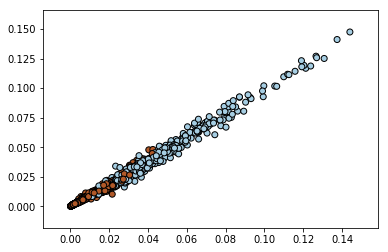

In [41]:
# Run prediction on the img_idx-th image
img_idx = 12

image_dir = "test_set_images/"  + "test_" + str(img_idx) +"/"
file = os.listdir(image_dir)[0]
Xi = extract_img_features(image_dir+file)
varlist1, varlist2 = calc_variance(load_image(image_dir+file))

Xi = np.concatenate((Xi, varlist1), axis=1)
Xi = np.concatenate((Xi, varlist2), axis=1)

Zi = model.predict(Xi)
plt.scatter(Xi[:, 4], Xi[:, 5], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

In [45]:
from mask_to_submission import *

In [46]:
import scipy.misc

In [43]:
PIXEL_DEPTH = 255
def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * PIXEL_DEPTH).round().astype(np.uint8)
    return rimg


def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*PIXEL_DEPTH

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

In [47]:
w = img.shape[0]
h = img.shape[1]
test_dir = './testing/groundtruth/'
test_overlay_dir = './testing/overlay/'

if not os.path.exists(test_dir):
    os.makedirs(test_dir)
    
if not os.path.exists(test_overlay_dir):
    os.makedirs(test_overlay_dir)    

for i in range(1,51):
    image_dir = "./test_set_images/"  + "test_" + str(i) +"/"
    file = os.listdir(image_dir)[0]
    Xi = extract_img_features(image_dir+file)
    
    varlist1, varlist2 = calc_variance(load_image(image_dir+file))

    Xi = np.concatenate((Xi, varlist1), axis=1)
    Xi = np.concatenate((Xi, varlist2), axis=1)
    
    Zi = model.predict(Xi)

    predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)

    img = load_image("./test_set_images/"  + "test_" + str(i) +"/test_{0}.png".format(i))
    new_img = make_img_overlay(img, predicted_im)
    
    img_file_name = test_dir + 'satImage_' + '%.3d'%i + '.png'
    img_overlay_name = test_overlay_dir + 'satImage_' + '%.3d'%i + '.png'
    scipy.misc.imsave(img_overlay_name, new_img)
    scipy.misc.imsave(img_file_name, predicted_im)

In [48]:
submission_filename = 'dummy_submission.csv'
image_filenames = []
for i in range(1, 51):
    image_filename = 'testing/groundtruth/satImage_' + '%.3d' % i + '.png'
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)